## Neural Net

In [2]:
import warnings
import time
from tqdm import tqdm
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

from _util.custom_plotting import corr_heatmap, histogram_boxplot, horizontal_bar, heatmap_boxplot, simple_bar
from _util.make_confusion_matrix import make_cm
from _util.model_comparisons import *
from _util.custom_mem_opt import custom_mem_opt

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import PrettyPrinter

import gc

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

pd.options.mode.chained_assignment = None
pp = PrettyPrinter(width=41, compact=True)
root = './_pkls/'

### Set some options

In [3]:
warnings.simplefilter(action='ignore', category=NumbaDeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
np.seterr(divide = 'ignore') 

# Ensure that the current MacOS version is at least 12.3+, and 
# the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_available(), ", ", torch.backends.mps.is_built())

pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

pp = PrettyPrinter(width=100)

True ,  True


In [71]:
df = pd.read_pickle(root + 'final_data.pkl')
df.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.600000,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.555555,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.600000,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.666666,10.0,1.0,0.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667


In [72]:
df = custom_mem_opt(df)

Memory usage of properties dataframe is : 4283.495386123657  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1204.2280359268188  MB
This is  28.11320959578722 % of the initial size


In [73]:
df['order_diff'] = df.order_number - df.last_ordered_in
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [74]:
df.head()

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0


In [75]:
print(df.shape)

(8474661, 68)


In [76]:
df.reordered = df.reordered.astype(int)
#df.groupby('reordered', group_keys=False).apply(lambda x: x.sample(frac=0.30))

In [77]:
print(df.shape)

(8474661, 68)


In [81]:
df_red, df_val = train_test_split(df, test_size=0.3, stratify=df['reordered'])
#df_red = df.groupby('reordered', group_keys=False).apply(lambda x: x.sample(frac=0.3))

In [82]:
y_val = df_val.reordered
X_val = df_val.drop(["reordered", 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], axis = 1)
print(X_val.shape)

(2542399, 64)


In [83]:
y = df_red.reordered
X = df_red.drop(["reordered", 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], axis = 1)
print(X.shape)

(5932262, 64)


In [84]:
X, y = make_classification(n_classes=2
                           , class_sep=2
                           , weights=[0.1, 0.9]
                           , n_informative=3
                           , n_redundant=1
                           , flip_y=0
                           , n_features=X.shape[1]
                           , n_clusters_per_class=1
                           , n_samples=len(X)
                           , random_state=10)
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({1: 5339035, 0: 593227})


In [85]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 5339035, 0: 5339035})


## Train-Test Split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.3)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (7474649, 64)
Shape of y_train:  (7474649,)
Shape of X_test:  (3203421, 64)
Shape of y_test:  (3203421,)


In [87]:
samples_dict = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'y_val': y_val, 'X_val': X_val}
models_dict = {}

# Logistic Regression - pytorch NN

In [88]:
if torch.backends.mps.is_available():
    device = "mps"
    processor = torch.device("mps")
    x = torch.ones(1, device=processor)
    print (x)
else:
    print ("GPU device not found.")

tensor([1.], device='mps:0')


In [65]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [89]:
X_train_t = torch.tensor(X_train, dtype=torch.float, device=processor)
X_test_t = torch.tensor(X_test, dtype=torch.float, device=processor)
y_train_t = torch.tensor(y_train, dtype=torch.float, device=processor).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float, device=processor).view(-1, 1)

In [90]:
class LogReg(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.layer0 = nn.Linear(in_features=num_features, out_features=round(num_features/2))
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(round(num_features/2), 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer0(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.sigmoid(x)
        return x
    
def calculate_accuracy(preds, actuals):
    
    with torch.no_grad():
        rounded_preds = torch.round(preds)
        num_correct = torch.sum(rounded_preds == actuals)
        accuracy = num_correct/len(preds)
        
    return accuracy

In [91]:
train_losses = []
test_losses  = []
train_accs = []
test_accs  = []
iter = 0

n_features = X_train_t.shape[1]

model=LogReg(n_features).to(device)

criterion=torch.nn.MSELoss().to(device)

optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

start = time.perf_counter()
epochs=1200
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    # Forward propagation
    train_preds_t=model(X_train_t)
    train_loss_t=criterion(train_preds_t,y_train_t).to(device)

    # Backward propagation
    train_loss_t.backward()

    # Gradient descent step
    optimizer.step()
    
    # Reset gradient
    optimizer.zero_grad()
    
    # Calculating the loss and accuracy for the test dataset
    # Predicting test data #b
    with torch.no_grad():
        test_preds_t = model(X_test_t)
        test_loss_t  = criterion(test_preds_t, y_test_t).to(device)

    # Calculate accuracy #c
    train_acc_t = calculate_accuracy(train_preds_t, y_train_t)
    test_acc_t  = calculate_accuracy(test_preds_t, y_test_t)

    # Store training history #f
    train_losses.append(train_loss_t.item())
    test_losses.append(test_loss_t.item())
    train_accs.append(train_acc_t.item())
    test_accs.append(test_acc_t.item())
    
    # Print training data #g
    if epoch%int(epochs/10)==0:
        print(f'Epoch: {epoch} \t|' \
            f' Train loss: {np.round(train_loss_t.item(),4)} \t|' \
            f' Test loss: {np.round(test_loss_t.item(),4)} \t|' \
            f' Train acc: {np.round(train_acc_t.item(),4)} \t|' \
            f' Test acc: {np.round(test_acc_t.item(),4)}')
        
end = time.perf_counter()

Training Epochs:   0%|          | 0/1200 [00:00<?, ?it/s]

Training Epochs:   0%|          | 1/1200 [00:04<1:20:07,  4.01s/it]

Epoch: 0 	| Train loss: 0.2654 	| Test loss: 0.2628 	| Train acc: 0.4387 	| Test acc: 0.447


Training Epochs:  10%|█         | 121/1200 [00:29<03:46,  4.76it/s]

Epoch: 120 	| Train loss: 0.0572 	| Test loss: 0.0566 	| Train acc: 0.9627 	| Test acc: 0.9628


Training Epochs:  20%|██        | 241/1200 [00:54<03:19,  4.82it/s]

Epoch: 240 	| Train loss: 0.0321 	| Test loss: 0.032 	| Train acc: 0.9688 	| Test acc: 0.9688


Training Epochs:  30%|███       | 361/1200 [01:19<02:55,  4.77it/s]

Epoch: 360 	| Train loss: 0.0265 	| Test loss: 0.0265 	| Train acc: 0.9709 	| Test acc: 0.9708


Training Epochs:  40%|████      | 481/1200 [01:45<02:33,  4.68it/s]

Epoch: 480 	| Train loss: 0.0243 	| Test loss: 0.0243 	| Train acc: 0.9723 	| Test acc: 0.9722


Training Epochs:  50%|█████     | 601/1200 [02:10<02:06,  4.75it/s]

Epoch: 600 	| Train loss: 0.023 	| Test loss: 0.023 	| Train acc: 0.9731 	| Test acc: 0.973


Training Epochs:  60%|██████    | 721/1200 [02:36<01:40,  4.76it/s]

Epoch: 720 	| Train loss: 0.0222 	| Test loss: 0.0222 	| Train acc: 0.9738 	| Test acc: 0.9736


Training Epochs:  70%|███████   | 841/1200 [03:01<01:15,  4.74it/s]

Epoch: 840 	| Train loss: 0.0215 	| Test loss: 0.0216 	| Train acc: 0.9744 	| Test acc: 0.9742


Training Epochs:  80%|████████  | 961/1200 [03:26<00:50,  4.74it/s]

Epoch: 960 	| Train loss: 0.0209 	| Test loss: 0.021 	| Train acc: 0.975 	| Test acc: 0.9747


Training Epochs:  90%|█████████ | 1081/1200 [03:51<00:25,  4.75it/s]

Epoch: 1080 	| Train loss: 0.0203 	| Test loss: 0.0204 	| Train acc: 0.9755 	| Test acc: 0.9753


Training Epochs: 100%|██████████| 1200/1200 [04:17<00:00,  4.67it/s]


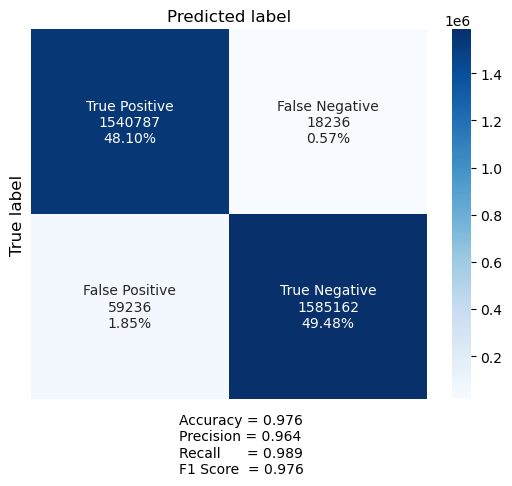

,Model,Conv. Time (sec.),Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1-Score,Test_F1-Score
0,Torch LogReg,257.0198,0.976123,0.975816,0.988965,0.988627,0.964179,0.963977,0.976415,0.976146


In [92]:
pred_train = prob_to_label(model(X_train_t).cpu().detach().numpy())
pred_test = prob_to_label(model(X_test_t).cpu().detach().numpy())
samples_dict['pred_train'] = pred_train
samples_dict['pred_test'] = pred_test

# Compute and print the confusion matrix and classification report
#Creating confusion matrix
make_cm([y_test,pred_test])

#Models and sample dicts
models_dict['Torch LogReg'] = {'pred_train':pred_train, 'pred_test':pred_test, 'est_time':end-start}

#Print model comparisons
model_comparisons(models_dict, samples_dict)